In [72]:
#Importing the Libraries
import numpy as np
import pandas as pd
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

In [73]:
data = pd.read_csv("dataset/marketing_campaign.csv", sep="\t").dropna()
data.shape

(2216, 29)

In [74]:
data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"], format="%d-%m-%Y")

print("The newest customer's enrolment was on:", data["Dt_Customer"].max().date())
print("The oldest customer's enrolment was on:", data["Dt_Customer"].min().date())

The newest customer's enrolment was on: 2014-06-29
The oldest customer's enrolment was on: 2012-07-30


In [75]:
#Created a feature "Customer_For"
d1 = data['Dt_Customer'].max()
data['Customer_For'] = (d1 - data['Dt_Customer']).dt.days
data["Customer_For"] = pd.to_numeric(data["Customer_For"], errors="coerce")

In [76]:
# Feature Engineering
# Calculate age of customers based on birth year
data["Age"] = 2021 - data["Year_Birth"]

# Calculate total spending across various items
data["Spent"] = data[["MntWines", "MntFruits", "MntMeatProducts", "MntFishProducts", "MntSweetProducts", "MntGoldProds"]].sum(axis=1)

# Determine living situation based on marital status
living_situation_map = {
    "Married": "Partner",
    "Together": "Partner",
    "Absurd": "Alone",
    "Widow": "Alone",
    "YOLO": "Alone",
    "Divorced": "Alone",
    "Single": "Alone"
}
data["Living_With"] = data["Marital_Status"].replace(living_situation_map)

# Calculate total number of children in the household
data["Children"] = data["Kidhome"] + data["Teenhome"]

# Calculate family size based on living situation and children count
data["Family_Size"] = data["Living_With"].replace({"Alone": 1, "Partner": 2}) + data["Children"]

# Create a binary indicator for parenthood
data["Is_Parent"] = (data["Children"] > 0).astype(int)

# Segment education levels into three groups
education_map = {
    "Basic": "Undergraduate",
    "2n Cycle": "Undergraduate",
    "Graduation": "Graduate",
    "Master": "Postgraduate",
    "PhD": "Postgraduate"
}
data["Education"] = data["Education"].replace(education_map)

# Rename spending columns for clarity
data = data.rename(columns={
    "MntWines": "Wines",
    "MntFruits": "Fruits",
    "MntMeatProducts": "Meat",
    "MntFishProducts": "Fish",
    "MntSweetProducts": "Sweets",
    "MntGoldProds": "Gold"
})

# Drop redundant features
features_to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
data = data.drop(features_to_drop, axis=1)


In [77]:
# Filter out outliers based on age and income
data = data[(data["Age"] < 90) & (data["Income"] < 600000)]

# Calculate the number of data points after removing outliers
total_data_points = len(data)
print("The total number of data points after removing outliers is:", total_data_points)

The total number of data points after removing outliers is: 2212


In [78]:
from sklearn.preprocessing import LabelEncoder

# Get list of categorical variables
object_cols = data.select_dtypes(include=['object']).columns.tolist()
print("Categorical variables in the dataset:", object_cols)

# Label encode the categorical variables
LE = LabelEncoder()
data[object_cols] = data[object_cols].apply(lambda col: LE.fit_transform(col))

print("All features are now numerical")


Categorical variables in the dataset: ['Education', 'Living_With']
All features are now numerical


In [79]:
from sklearn.preprocessing import StandardScaler

# Drop columns directly from the original data variable
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response']
data.drop(cols_del, axis=1, inplace=True)

# Scale the remaining features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
scaled_data = pd.DataFrame(scaled_data, columns=data.columns)

print("All features are now scaled")

All features are now scaled


In [80]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3).fit(scaled_data)
PCA_data = pd.DataFrame(pca.transform(scaled_data), columns=(["col1","col2", "col3"]))

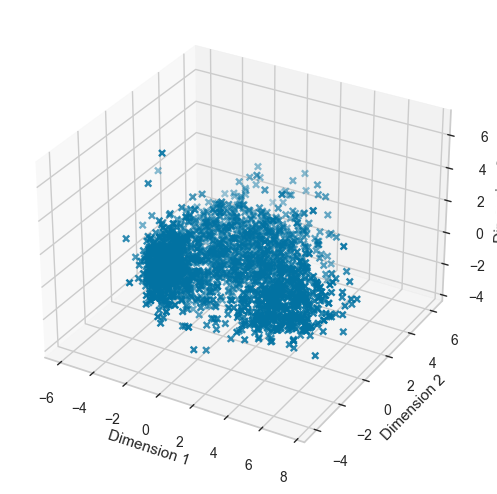

In [81]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Extract PCA components
x = PCA_data["col1"]
y = PCA_data["col2"]
z = PCA_data["col3"]

# Plotting in 3D
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x, y, z, marker="x")
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")
ax.set_zlabel("Dimension 3")
plt.show()


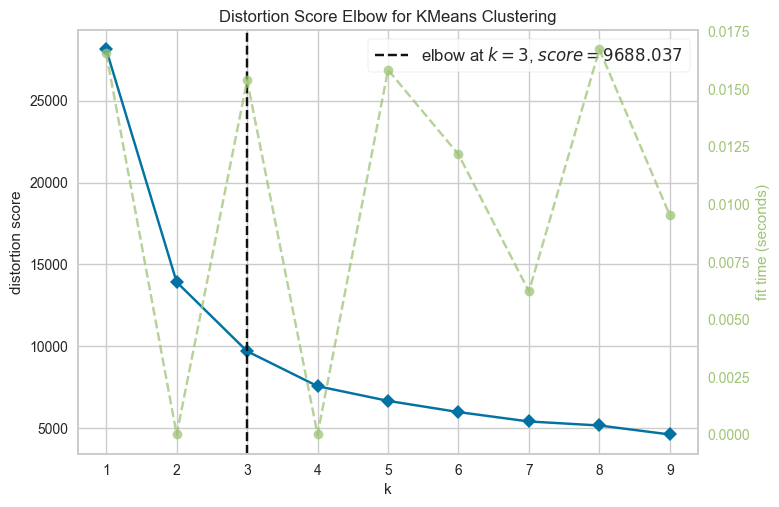

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [82]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

# Initialize KMeans and the KElbowVisualizer directly
visualizer = KElbowVisualizer(KMeans(), k=(1, 10))

# Fit the visualizer to PCA data
visualizer.fit(PCA_data)

# Visualize the elbow plot
visualizer.show()


In [83]:
from sklearn.cluster import AgglomerativeClustering

# Initialize Agglomerative Clustering model
AC = AgglomerativeClustering(n_clusters=visualizer.elbow_value_)

# Fit model and predict clusters on PCA_data
PCA_data['Clusters'] = AC.fit_predict(PCA_data)

# Add the Clusters feature to the original dataframe
data['Clusters'] = PCA_data['Clusters'].values

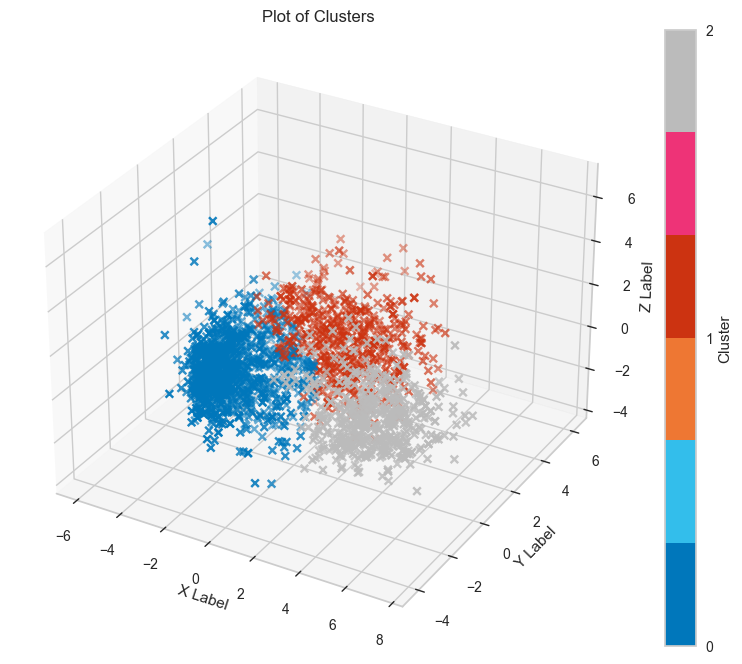

In [84]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors

# Define the figure and axis for 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Define colormap for clusters
cmap = colors.ListedColormap(["#0077BB", "#33BEEB", "#EE7733", "#CC3311", "#EE3377", "#BBBBBB"])

# Scatter plot with clusters colored by 'Clusters' column
scatter = ax.scatter(x, y, z, s=30, c=PCA_data["Clusters"], marker='x', cmap=cmap)
ax.set_title("Plot of Clusters")
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# Add colorbar for the clusters
cbar = plt.colorbar(scatter, ticks=[0, 1, 2, 3])  # Adjust ticks as needed
cbar.set_label('Cluster')

plt.show()